In [1]:
import torch 
import matplotlib.pyplot as plt 
import numpy as np
from cipher import *
from scheme import *

In [2]:
def plot_anno_heatmap(data):
    nx, ny = data.shape

    fig, ax = plt.subplots()
    im = ax.imshow(data)

    # Loop over data dimensions and create text annotations.
    for i in range(nx):
        for j in range(ny):
            text = ax.text(j, i, data[i, j],
                        ha="center", va="center", color="w")

In [2]:
myring = Ring(seed=1234)
parms = Parameters(logp = 30, logq = 500, logn =13)
nslots = 2**(parms.logn-1) # -1? 
context = Context(parms, myring)

sk = context.generate_secret_key()

print(context.params)

keys = {"mult":context.generate_mult_key(),
        "rot":{'1':'hi1',
               '2':'hi2',
               '4':'hi4',
               '8':'hi8'}}
ev = Evaluator(keys, context) # Evaluator도 그냥 context만 넣게 할까? 

encoder = Encoder(context)
encryptor = Encryptor(context)

decryptor = Decryptor(sk)

 logp: 30
 logq: 500 
 logn: 13


In [5]:
import ResNet20
from approximate import approx_relu, approx_sign

activation = lambda x : 40 * approx_relu(x/40, degree = 4, repeat=3)

org_model = ResNet20.ResNet9(activation=activation)


fn_param = "ResNet9avg_minimaxReLU.pt"
trained_param = torch.load(fn_param)
trained_param = {k: v.cpu() for k, v in trained_param.items()} # to cpu()
org_model.load_state_dict(trained_param)
org_model.eval() ## If not eval(), running_mean and running_var of batch_norm changes

# To numpy
params_np = {k: v.numpy() for k, v in trained_param.items()}

In [6]:
org_model

ResNet9(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.9, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (maxpool): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (basicblock1): BasicBlock(
    (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (shortcut): Sequential()
  )
  (conv3): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1,

In [8]:
def Gaz_siso(ci, co, fw, fh):
    n_rot = ci * fw * fh
    n_mult = co * ci * fw * fh
    n_add = co * ci * fw * fh
    
    return n_rot, n_mult, n_add



In [9]:
nt = 8192 # Nslots or 16384

# Count Rotation & multiplication 
def Lee22_mult_conv(ci, co, fw, fh, ki=1, ko=1):
    ti = np.ceil(ci/ki**2).astype(int)
    to = np.ceil(co/ki**2).astype(int)
    hi = 32
    wi = 32
    
    ho = 32
    wo = 32
    #q = np.ceil(co/pi).astye(int) # parallel version

    pi = 2**(np.log2((nt/ki**2*hi*wi*ti)))
    po = 2**(np.log2((nt/ko**2*ho*wo*to)))
    n_rot = fh*fw -1 + co*(2*np.ceil(np.log2(ki)) + np.ceil(np.log2(ti)) + 1)

    n_mult = 

    n_add = 

    return n_rot, n_mult, n_add

SyntaxError: invalid syntax (3456591196.py, line 16)

In [40]:
from math import floor, ceil

## SumSlots(ct; m, p)

sparse ctxt의 효율적인 sum reduce

In [138]:
def sumslots(ctxt, m, p):
    # m: number of added slots
    # p: gap size
    ctxt_j =[ctxt]
    for j in range(1, floor(np.log2(m))+1):
        ctxt_j.append(ctxt_j[-1] + np.roll(ctxt_j[-1], 2**(j-1)*p)) # -?
        
    result = ctxt_j[-1].copy()
    for j in range(floor(np.log2(m))):
        if floor(m/2**j) % 2 == 1:
            result += np.roll(ctxt_j[j], floor(m/2**(j+1))*2**(j+1)*p)
    return result

In [139]:
arr = np.array([1,0,0,2,0,0,3,0,0,4,0,0,5,0,0,6,0,0,7,0,0,8,0,0,9,0,0,10,0,0,11,0,0,12,0,0,13,0,0])
#print(np.sum(arr))
sumslots(arr, 13, 3)

array([91,  0,  0, 91,  0,  0, 91,  0,  0, 91,  0,  0, 91,  0,  0, 91,  0,
        0, 91,  0,  0, 91,  0,  0, 91,  0,  0, 91,  0,  0, 91,  0,  0, 91,
        0,  0, 91,  0,  0])

### Vec

In [47]:
def VEC(tensor_img, ci = 3, wi = 4, hi = 4):
    vectorized = np.zeros((ci*wi*hi)) # or int(2**floor(np.log2(ci))) ?

    for i in range(wi*hi*ci):
        vectorized[i] = tensor_img[floor((i%(hi*wi))/wi),
                                    i % wi, floor(i/(hi*wi))]
    return vectorized

### Multiplexed Packing

In [ ]:
ch1 = np.arange(16).reshape(4,4)
ch2 = 10*np.arange(16).reshape(4,4)
ch3 = 100*np.arange(16).reshape(4,4)
#ch4 = np.zeros(16).reshape(4,4)
tensor_img = np.zeros((4,4,3))
tensor_img[:,:,0] = ch1
tensor_img[:,:,1] = ch2
tensor_img[:,:,2] = ch3

plt.imshow(tensor_img[:,:,0])

In [140]:
tensor_img.shape

(4, 4, 3)

In [141]:
from math import sqrt

In [145]:
# multplexed packing

def multiplex(tensor_data):
    """
        tensor_data: (H, W, C)
    """
    hi, wi, ci = tensor_data.shape
    
    ki = ceil(sqrt(ci))

    ti = np.ceil(ci/ki**2).astype(int)

    MP = np.zeros((ki*hi,ki*wi,ti))

    for i5 in range(ti):
        for i4 in range(ki*wi):
            for i3 in range(ki*hi):
                ind_last = ki**2*i5 + ki*(i3 % ki) + i4 % ki
                if ind_last < ci:
                    MP[i3,i4,i5] = tensor_data[floor(i3/ki), floor(i4/ki), ind_last]

    return MP

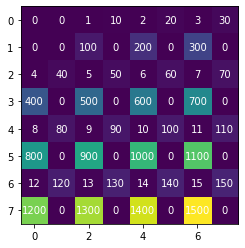

In [146]:
MP = multiplex(tensor_img)
plot_anno_heatmap(MP[:,:,0].astype(int))

In [147]:
tensor_img.astype(int)

array([[[   0,    0,    0],
        [   1,   10,  100],
        [   2,   20,  200],
        [   3,   30,  300]],

       [[   4,   40,  400],
        [   5,   50,  500],
        [   6,   60,  600],
        [   7,   70,  700]],

       [[   8,   80,  800],
        [   9,   90,  900],
        [  10,  100, 1000],
        [  11,  110, 1100]],

       [[  12,  120, 1200],
        [  13,  130, 1300],
        [  14,  140, 1400],
        [  15,  150, 1500]]])

## MultWgt(U;i1,i2,i)
transform a filter of $F_h \times F_w \times C_i \times C_o$ to 1D 


Before, we define multiplexed shifted weight tensor

In [ ]:
# Multiplexed 
fh = 3
fw = 3
co = 8 #(3->8)

U = np.zeros((fh,fw,co))
Up = np.zeros((ki*hi,ki*wi,ti))
for i3 in range(ki*hi):
    for i4 in range(ki*wi):
        for i5 in range(ti):
            condition = (ki**2(i5 + ki*(i3 % ki) + i4 % ki) >= ci) or floor(i3/ki) - (fw-1)/2 + int(not(i1 in [0,hi-1]))
            Up[i3,i4,i5]

In [ ]:
# Multiplexed selecting tensor

S = np.zeros((ko*ho, ko*wo, to))

In [ ]:
def multwgt()

# MultConv(ctxt, U)

In [ ]:
def multconv(ctxt, U):
    ctxt_d = np.zeros(len(ctxt))
    for i1 in range(fh):
        for i2 in range(fw):
            